# COVID-19 
(Previously known as nCoV-2019)
<img src='https://ars.els-cdn.com/content/image/3-s2.0-B9780443073670000409-f040-001-9780443073670.jpg'>

<b>Overview:</b> <br>
Tracking the COVID-19 viral infections around the world.

<b>Data Source:</b> <br>
Johns Hopkins University Center for Systems Science and Engineering (JHU CCSE) <br>
https://github.com/CSSEGISandData/COVID-19 <br>
The Lancet <br>
https://www.thelancet.com/pb-assets/Lancet/pdfs/S0140673620302117.pdf <br>
Clinical outcome (99 Cases)
<li> Remained in hospital 57 (58%)
<li> Discharged 31 (31%)
<li> Died 11 (11%)
<br>
JAMA (The Journal of the American Medical Association)<br>    
https://jamanetwork.com/journals/jama/fullarticle/2761044 <br>
<li>In this single-center case series of 138 hospitalized patients with confirmed NCIP in Wuhan, China, presumed hospital-related transmission of 2019-nCoV was suspected in 41% of patients, 26% of patients received ICU care, and mortality was 4.3%.

Generated on: 2020-03-09 22:51



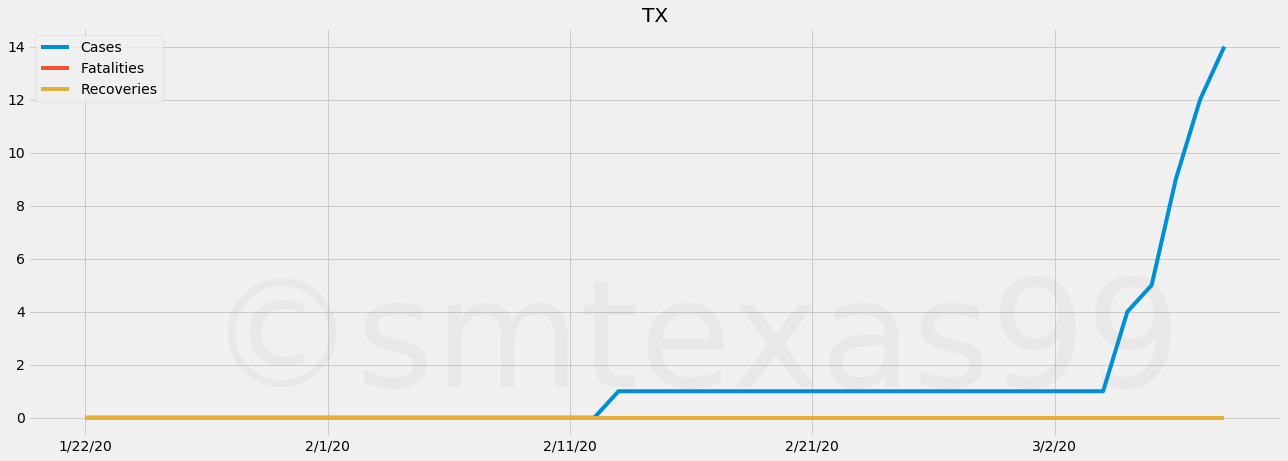

TX locations:
 |-- Collin County
 |-- Fort Bend County
 |-- Harris County
 |-- Montgomery County
 |-- San Antonio



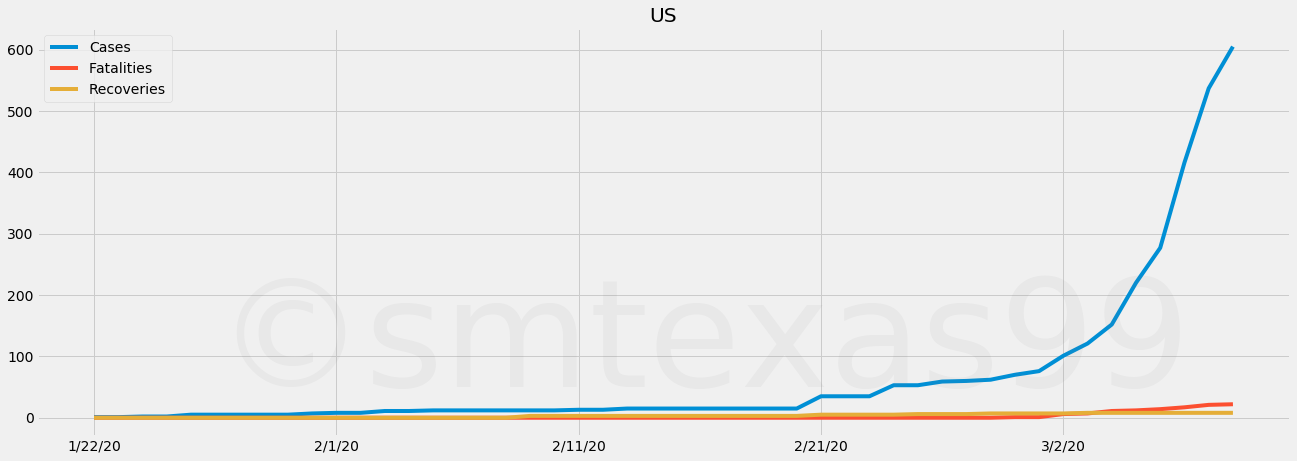

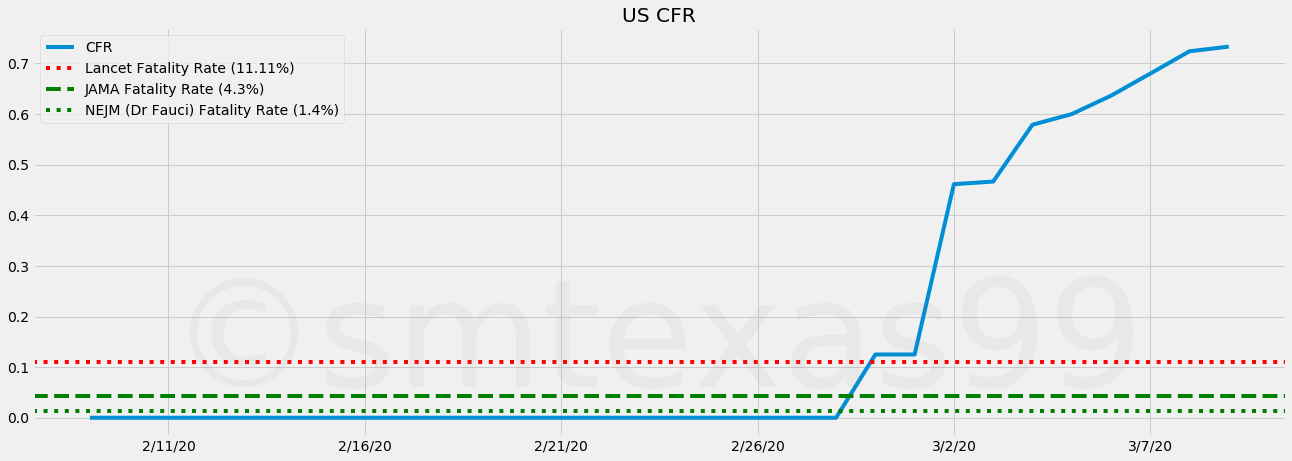

116 US locations:
 |--  Norfolk County, MA
 |-- Alameda County, CA
 |-- Bennington County, VT
 |-- Bergen County, NJ
 |-- Berkshire County, MA
 |-- Broward County, FL
 |-- Carver County, MN
 |-- Charleston County, SC
 |-- Charlotte County, FL
 |-- Chatham County, NC
 |-- Cherokee County, GA
 |-- Clark County, NV
 |-- Clark County, WA
 |-- Cobb County, GA
 |-- Collin County, TX
 |-- Contra Costa County, CA
 |-- Cook County, IL
 |-- Davidson County, TN
 |-- Davis County, UT
 |-- Delaware County, PA
 |-- Denver County, CO
 |-- Douglas County, CO
 |-- Douglas County, NE
 |-- Douglas County, OR
 |-- El Paso County, CO
 |-- Fairfax County, VA
 |-- Fairfield County, CT
 |-- Fayette County, KY
 |-- Fort Bend County, TX
 |-- Fresno County, CA
 |-- Fulton County, GA
 |-- Grafton County, NH
 |-- Grand Princess Cruise Ship
 |-- Grant County, WA
 |-- Harford County, MD
 |-- Harris County, TX
 |-- Harrison County, KY
 |-- Hendricks County, IN
 |-- Hillsborough, FL
 |-- Honolulu County, HI
 |-- Hudso

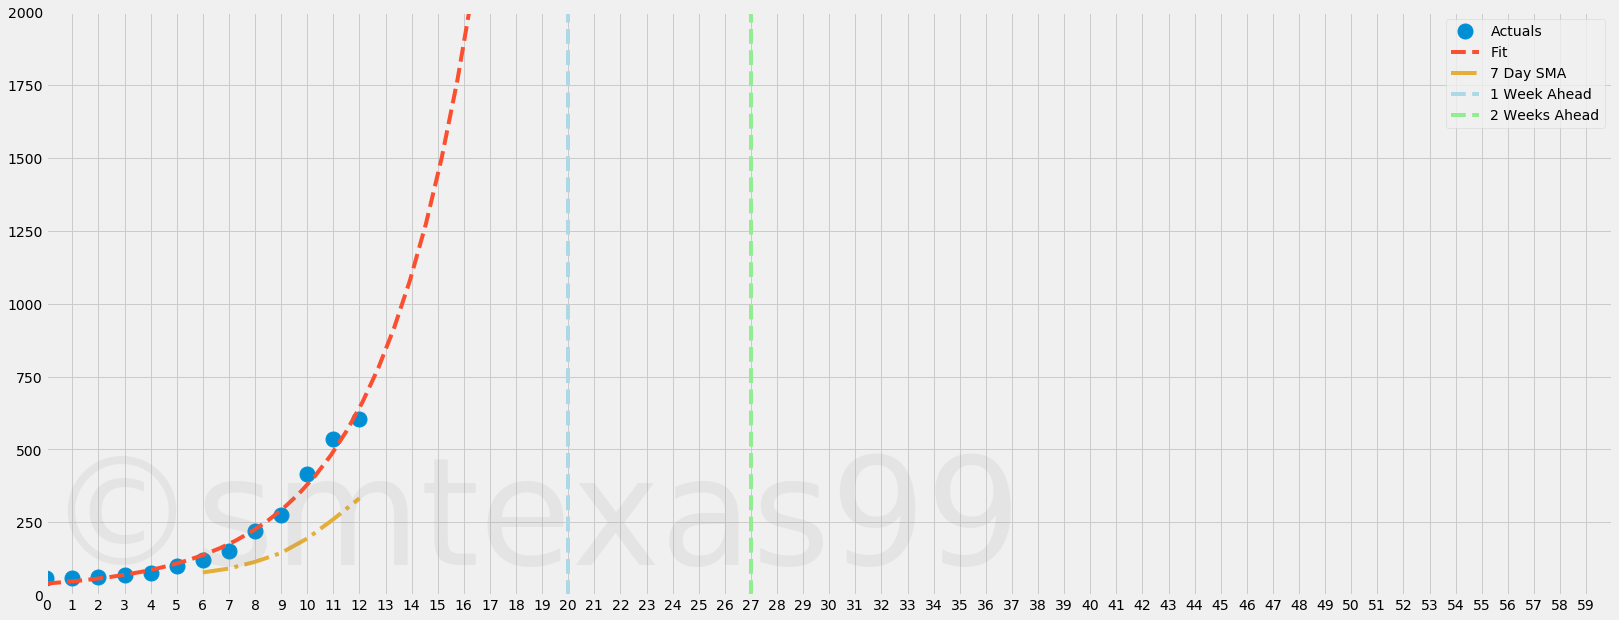

US FATALITIES    ( Generated on: 2020-03-09 22:51 )
**************************************************************
a =  11.165992644948174
b =  0.09777116526201125
c =  -12.83045294561731
R^2 = 0.9769
Next predicted data point   27
         7 Days from Now    66
        14 Days from Now    144
        21 Days from Now    297
        28 Days from Now    602
        30 Days from Now    735


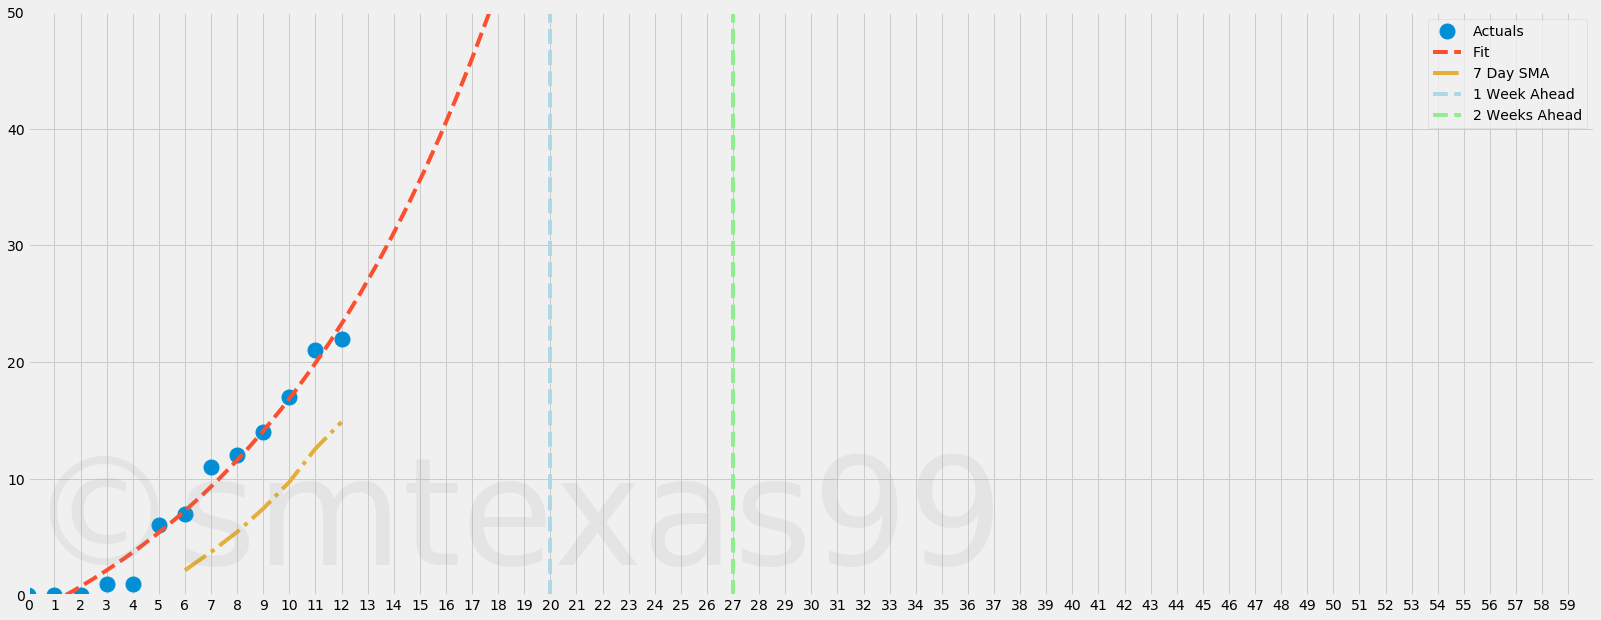



Global
------
Cases:       113,583
Recoveries:  62,512
Fatalities:   3,996
Remaining:   47,075
In ICU:       5,178


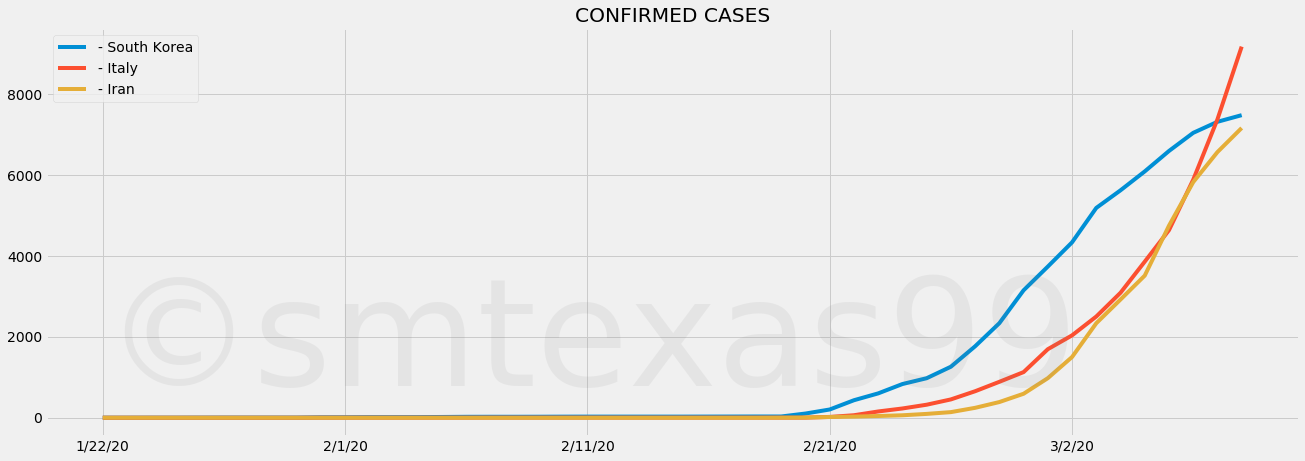

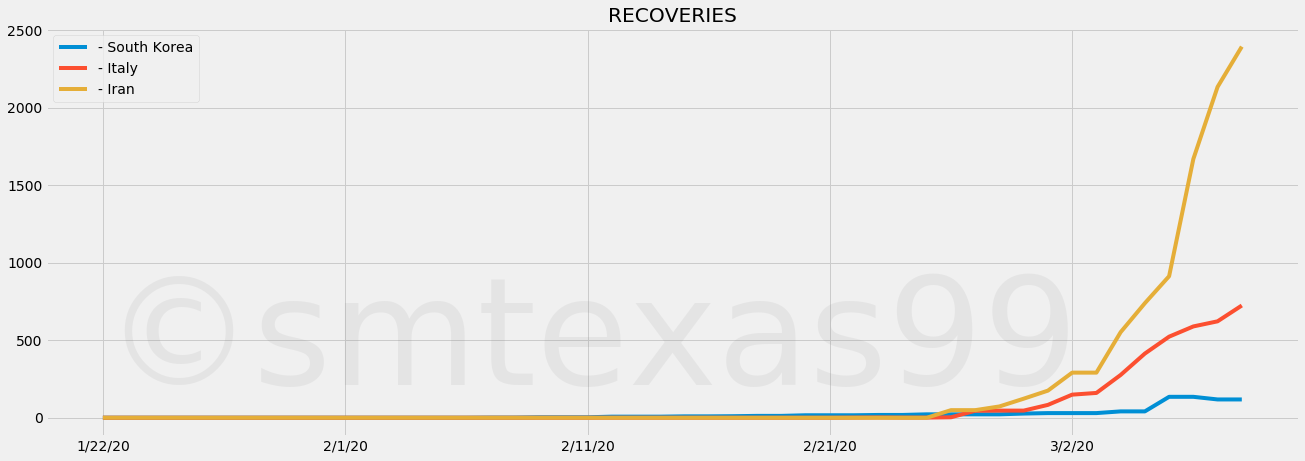

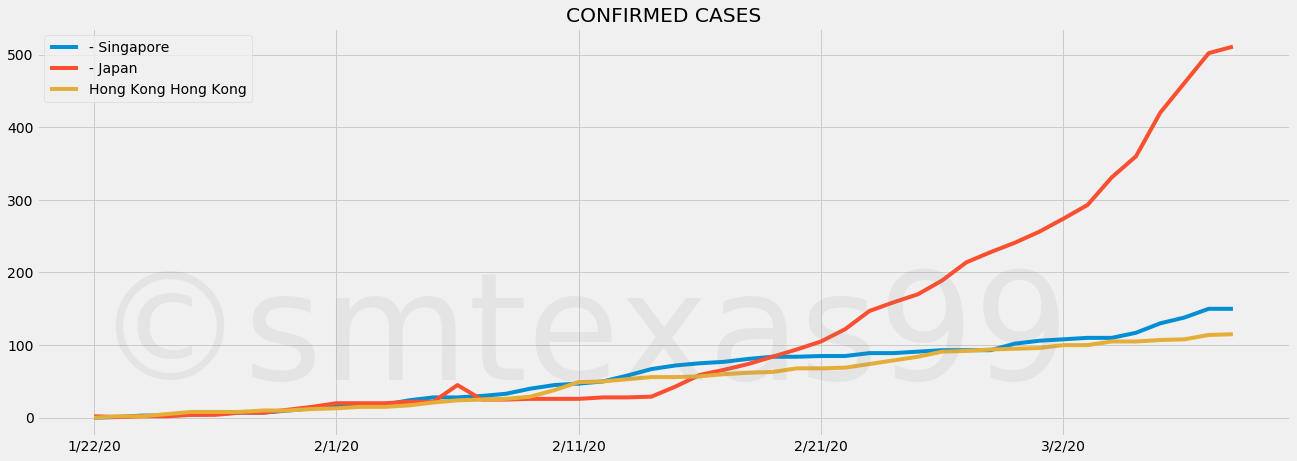

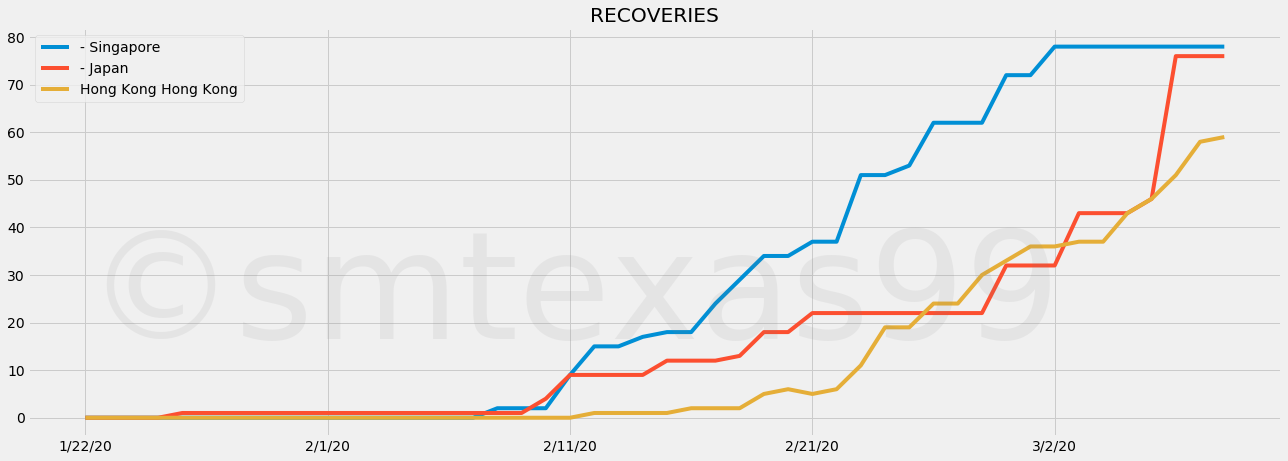

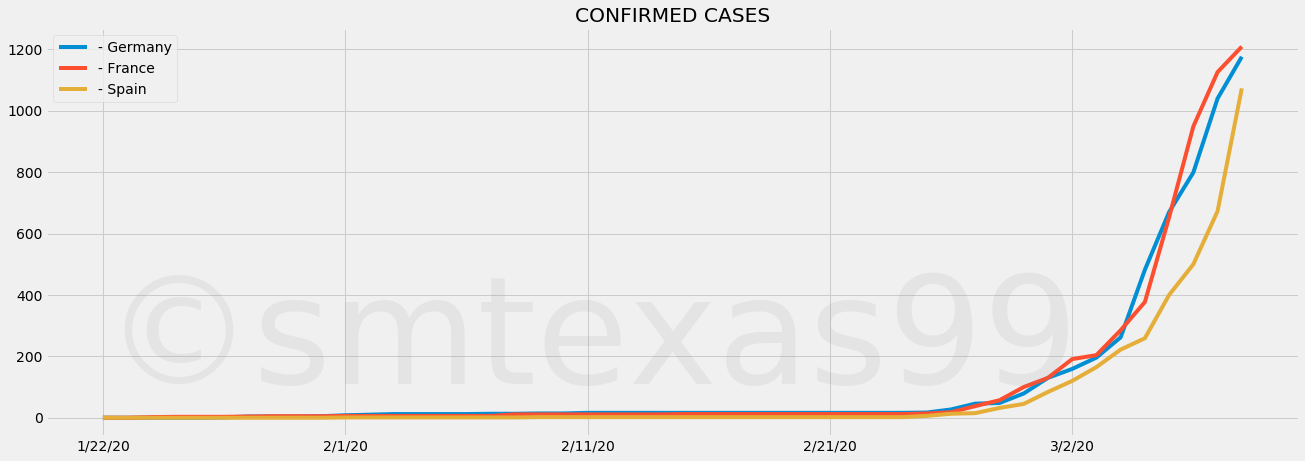

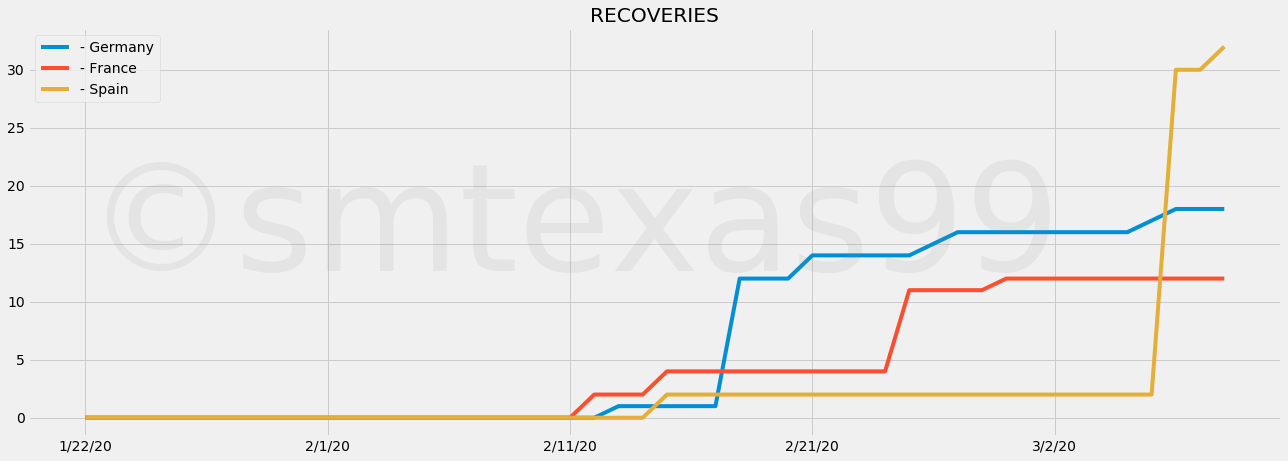

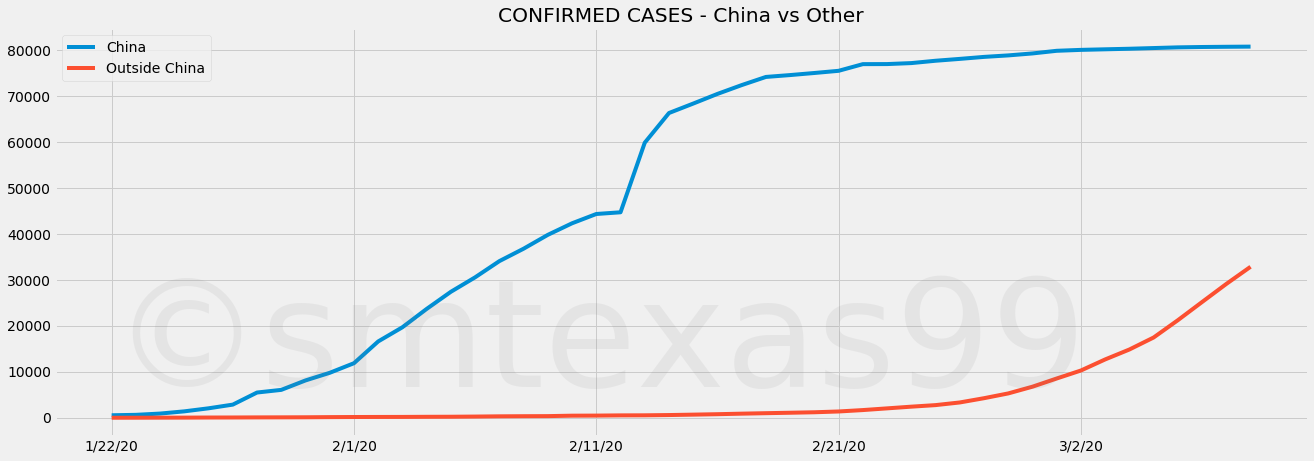

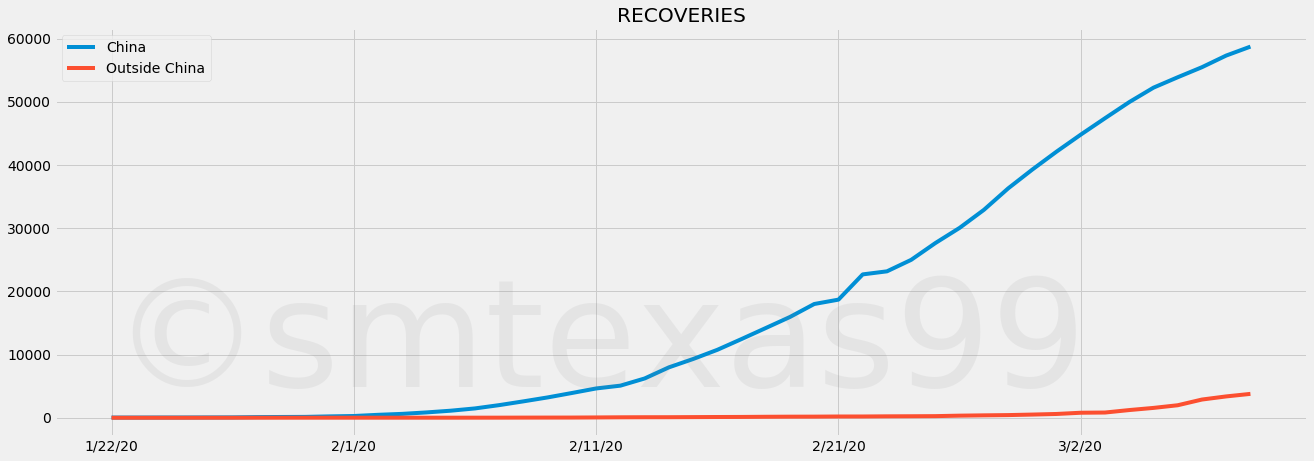

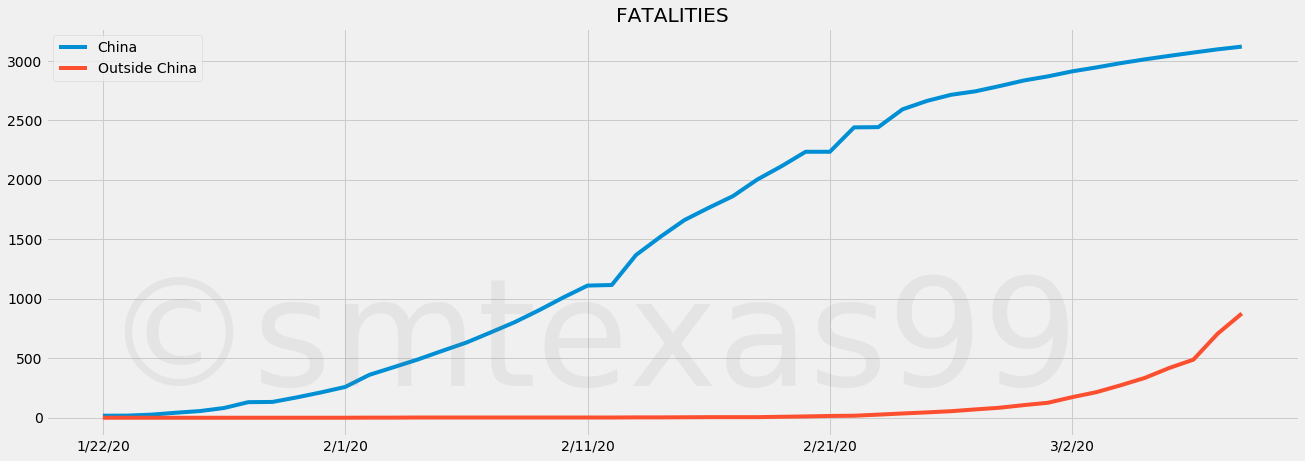

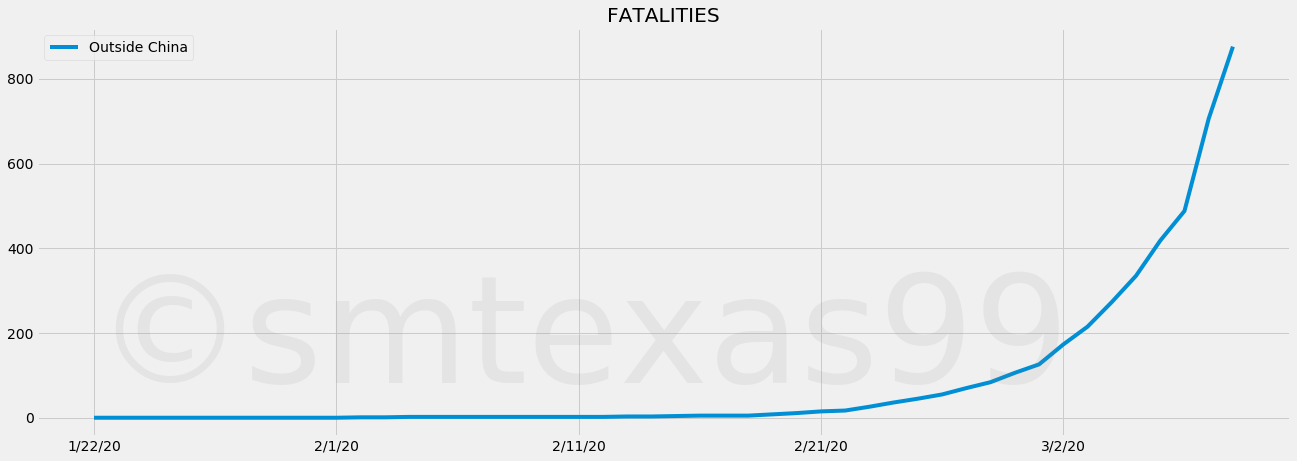

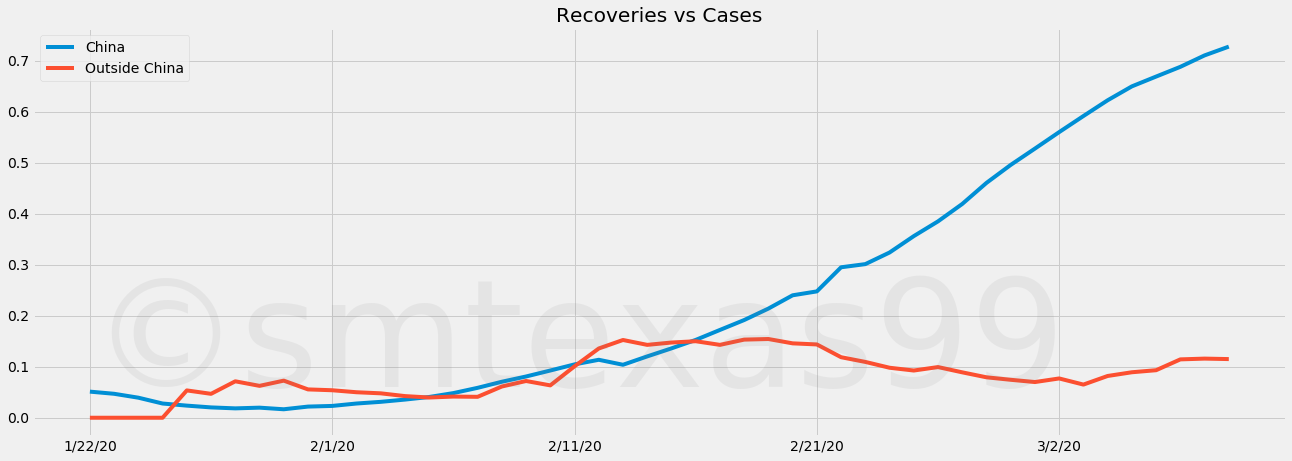

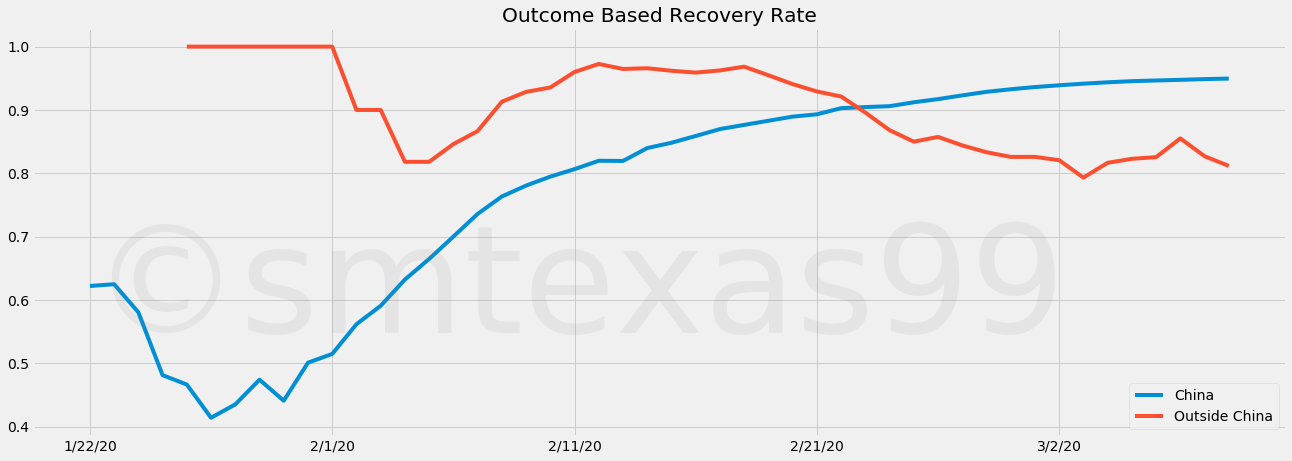

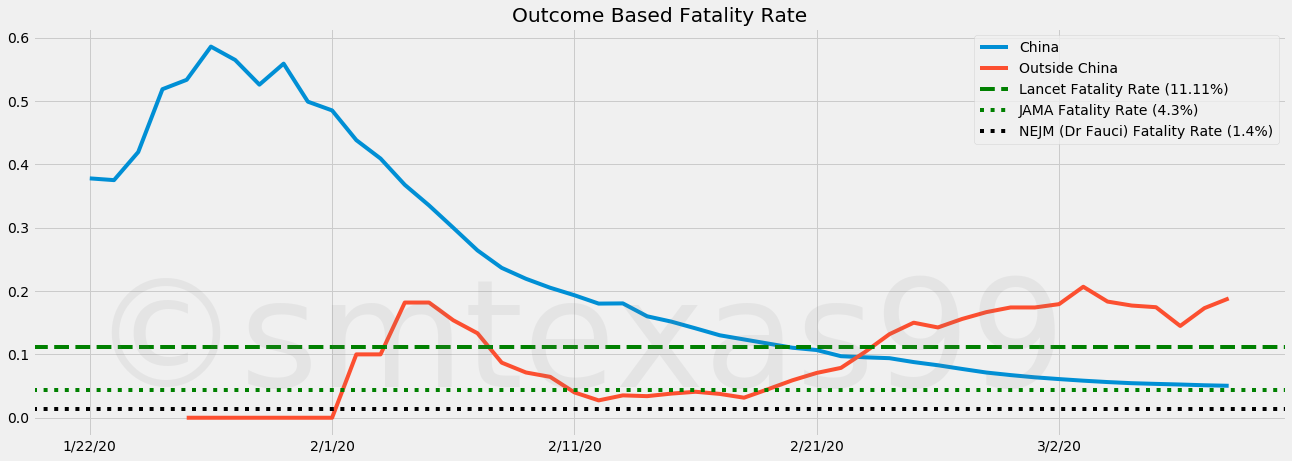

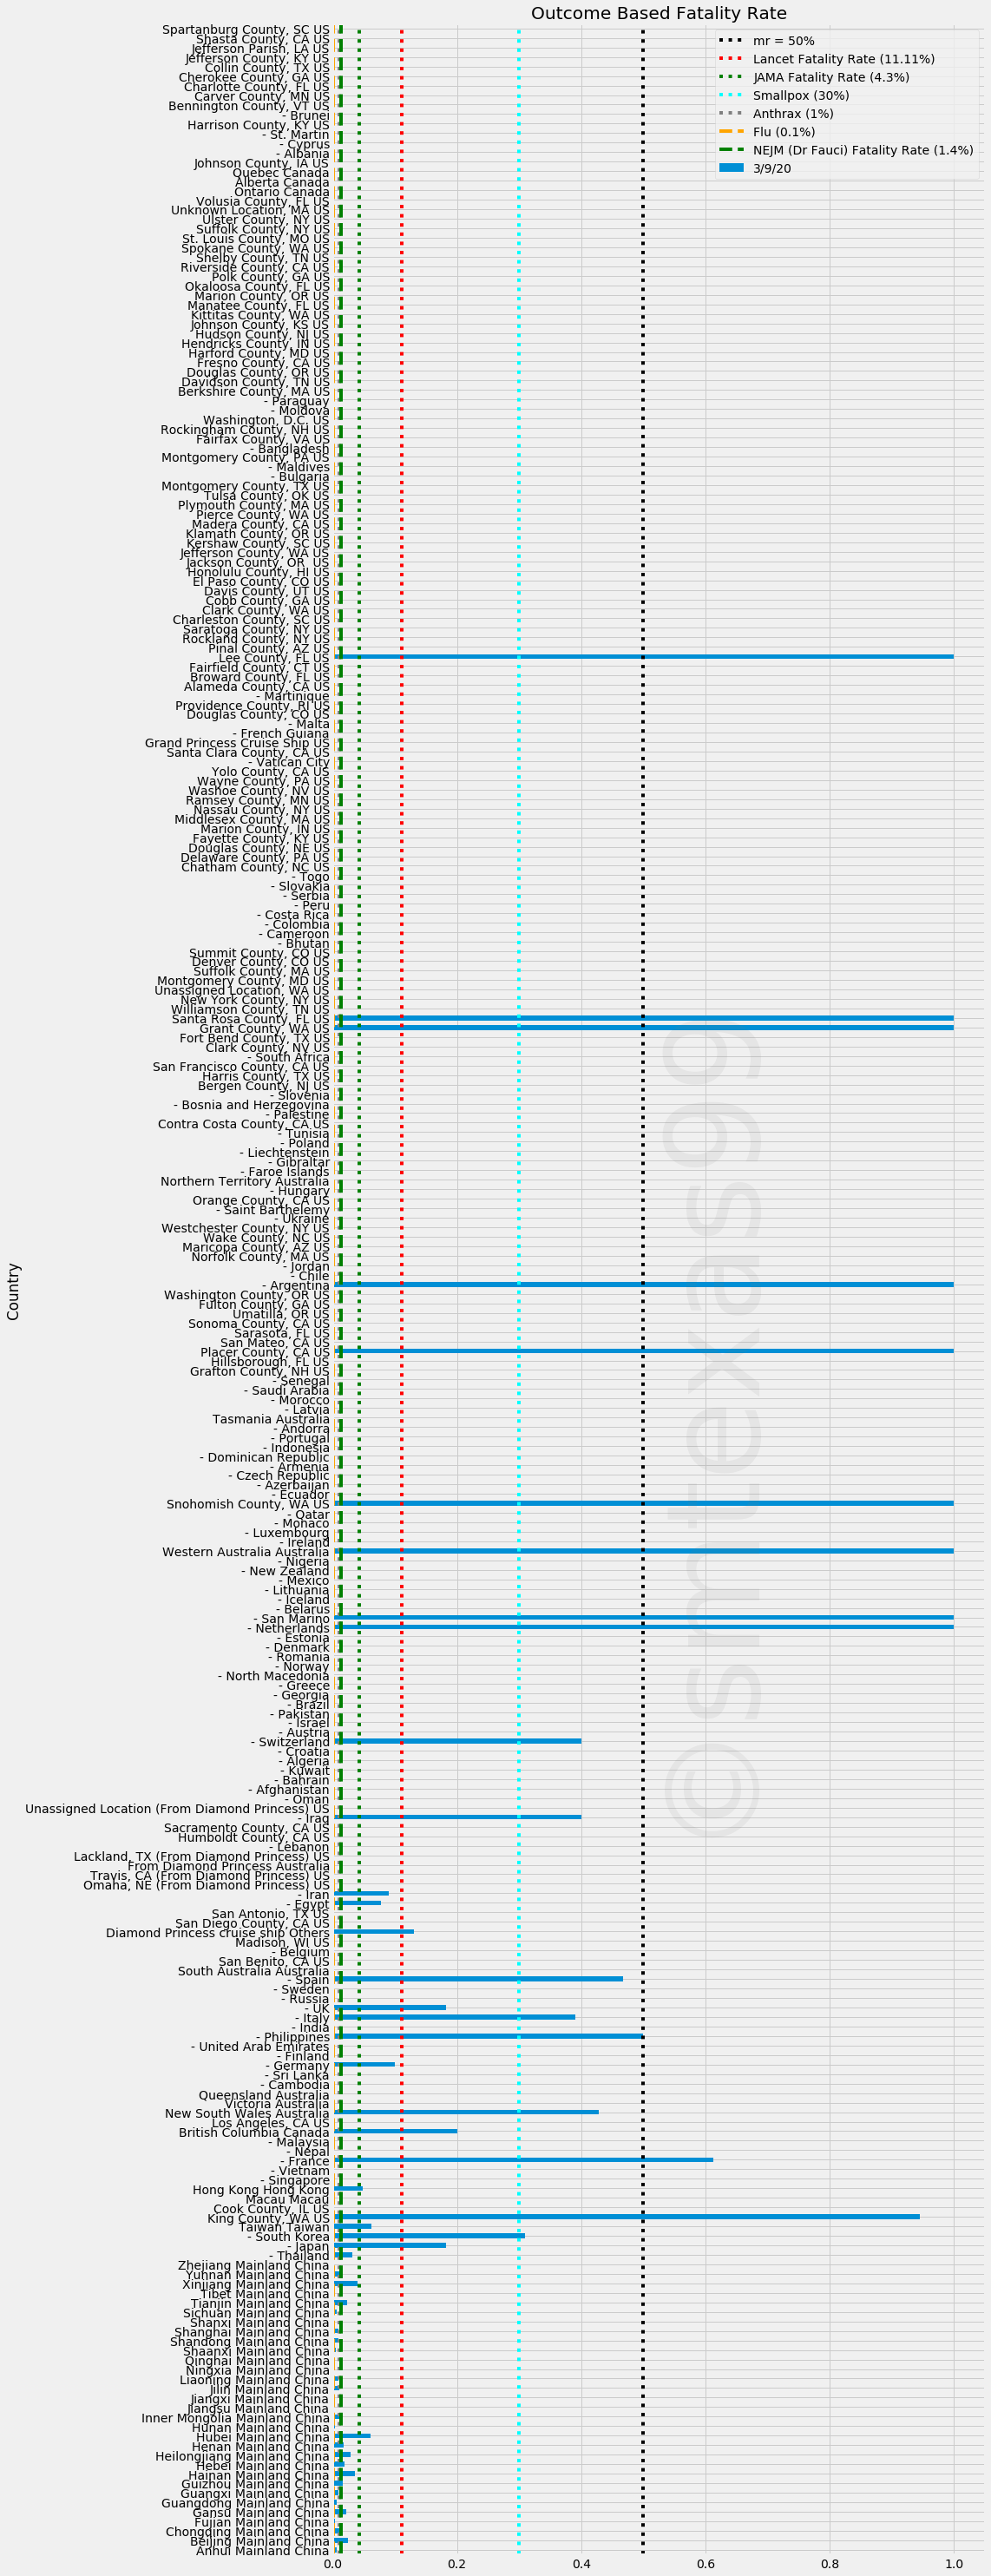

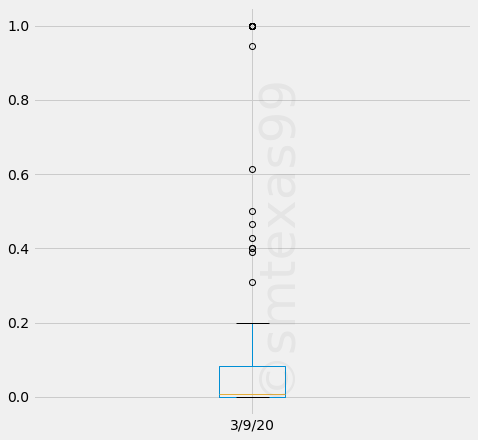

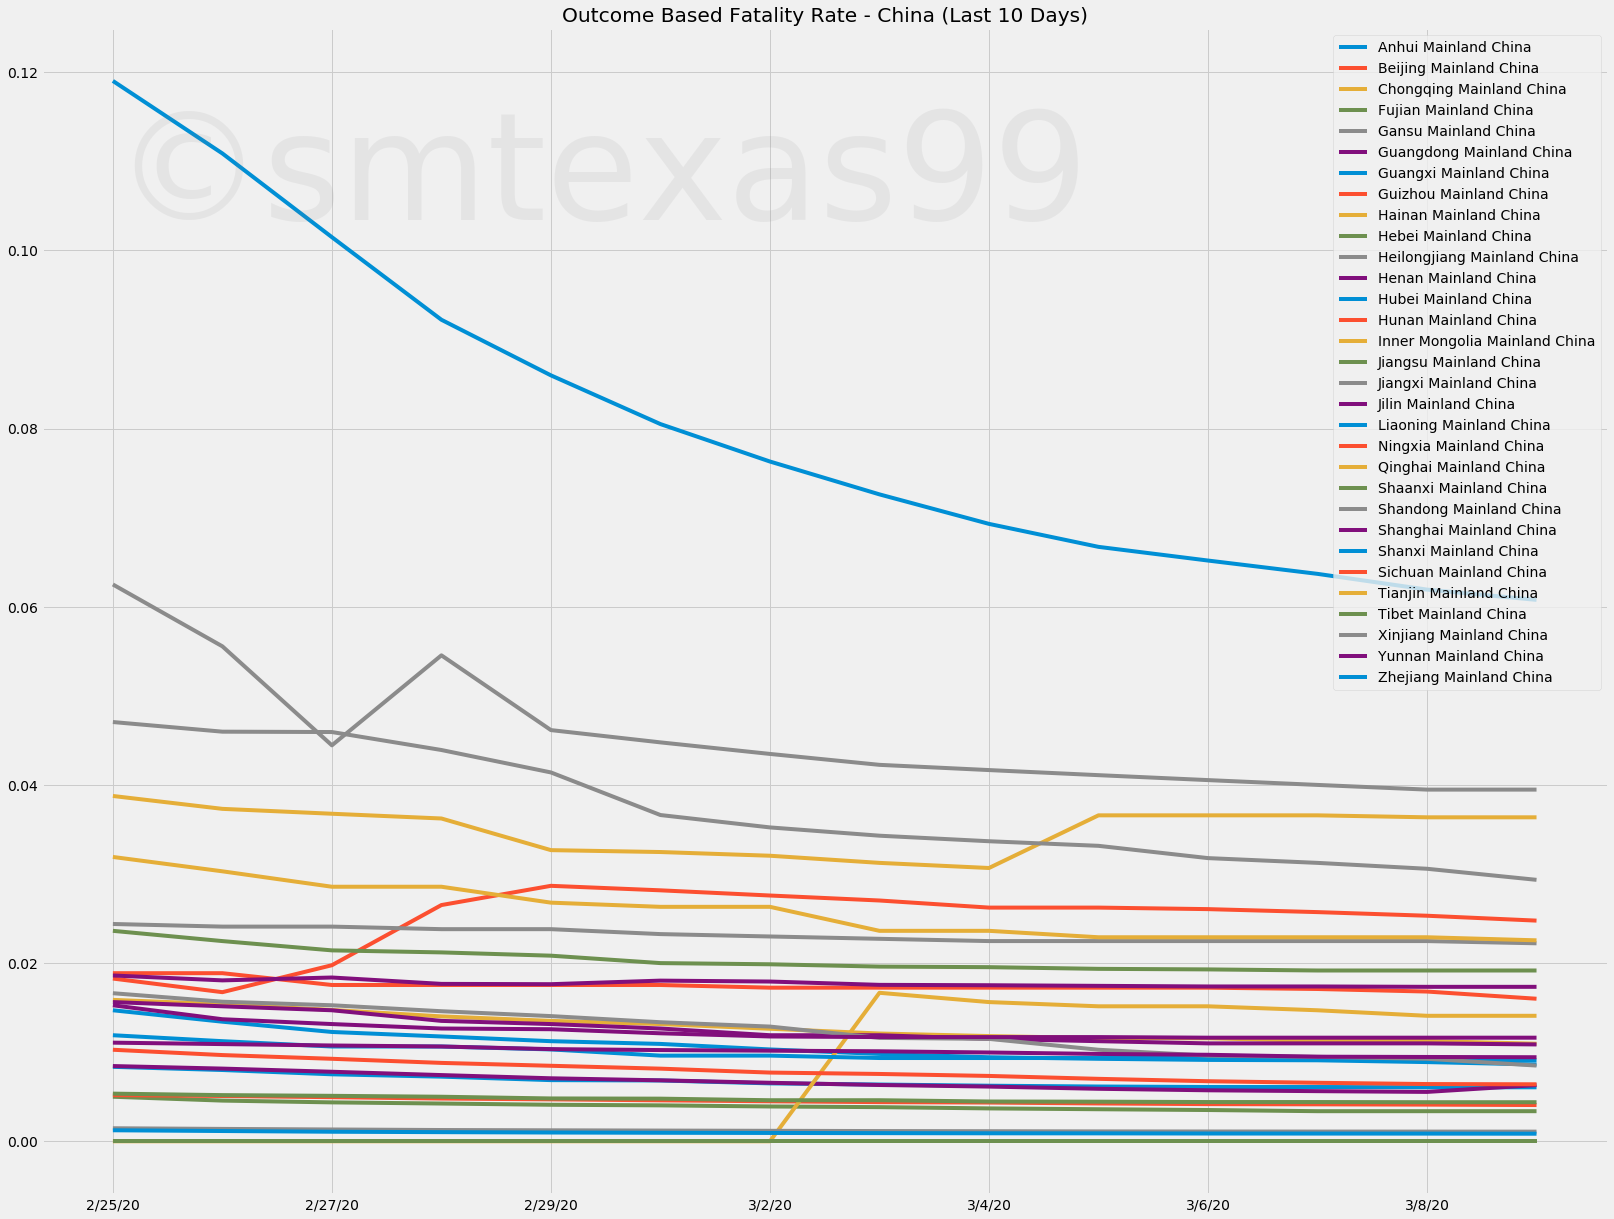

*********************************************************
Processing Time:                       0:00:07.142609
*********************************************************


In [1]:
%run smtexas99_covid19.py

Reference Rates: https://en.wikipedia.org/wiki/List_of_human_disease_case_fatality_rates